In [1]:
#Dependencies
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import pymysql
pymysql.install_as_MySQLdb()

In [2]:
#Import Datasets
#Draft Data
draft_file = "./Datasets/draft78.csv"
draft_df = pd.read_csv(draft_file)
#Salery Data
salary_file = "./Datasets/Player - Salaries per Year (1990 - 2017).xlsx"
salary_df = pd.read_excel(salary_file)
#Player Data
player_file = "./Datasets/player_data.csv"
player_df = pd.read_csv(player_file)

In [3]:
#Cleaning player_df and draft_df
player_df = player_df.drop(columns=['year_start', 'year_end'])
draft_df = draft_df.drop(columns=['Yrs'])

In [4]:
#Merging Salary and Draft
salary_df_2 = pd.merge(salary_df,  draft_df, how='inner', left_on='Player Name', 
                       right_on='Player', copy=False)
salary_df_2 = salary_df_2.drop(columns=['Player'])

In [5]:
#Merging New Salary Dataframe with Player Info and dropping unnecessary
final_df = pd.merge(salary_df_2, player_df, left_on='Player Name', right_on='name')
final_df = final_df.drop(columns=['Register Value','Team', 'name'])

In [27]:
#Renaming Columns to dump into SQL DB
final_df = final_df.rename(columns={
    'Player Name':'player_name', 'Salary in $': 'salary', 'Season Start': 'season_start',
    'Season End':'season_end', 'Full Team Name': 'team_name', 'Pick':'draft_rank',
    'draft_name':'draft'
})
final_df.head()

,player_name,salary,season_start,season_end,team_name,draft_rank,draft,position,height,weight,birth_date,college
0,A.C. Green,1750000,1990,1991,Los Angeles Lakers,23,1985,F-C,6-9,220.0,"October 4, 1963",Oregon State University
1,A.C. Green,1750000,1991,1992,Los Angeles Lakers,23,1985,F-C,6-9,220.0,"October 4, 1963",Oregon State University
2,A.C. Green,1750000,1992,1993,Los Angeles Lakers,23,1985,F-C,6-9,220.0,"October 4, 1963",Oregon State University
3,A.C. Green,1885000,1993,1994,Phoenix Suns,23,1985,F-C,6-9,220.0,"October 4, 1963",Oregon State University
4,A.C. Green,6472600,1994,1995,Phoenix Suns,23,1985,F-C,6-9,220.0,"October 4, 1963",Oregon State University


In [8]:
#Setting up connection to SQL
connection_string = "root:Piccolo7979@localhost/nba_db"
engine = create_engine(f'mysql://{connection_string}')
engine.table_names()

['nba_info']

In [28]:
#Load Data into SQL
final_df.to_sql(name='nba_info', con=engine, if_exists='append', index=False)

In [11]:
#Create new dataframe for analysis
final_a_df = final_df.groupby('player_name').max()
final_a_df.head()

,salary,season_start,season_end,team_name,draft_rank,draft_name,position,height,weight,birth_date,college
player_name,,,,,,,,,,,
A.C. Green,6473000,2000,2001,Phoenix Suns,23,1985,F-C,6-9,220.0,"October 4, 1963",Oregon State University
A.J. Bramlett,118974,1999,2000,Cleveland Caveliers,39,1999,C,6-10,227.0,"January 10, 1977",University of Arizona
A.J. English,406000,1993,1994,Washington Wizards,37,1990,G,6-3,175.0,"July 11, 1967",Virginia Union University
A.J. Guyton,465850,2002,2003,Golden State Warriors,32,2000,G,6-1,180.0,"February 12, 1978",Indiana University
A.J. Price,885120,2014,2015,Washington Wizards,52,2009,G,6-2,181.0,"October 7, 1986",University of Connecticut


In [12]:
#Converting height to inches
heights = final_a_df['height'].str.split('-', n = 1, expand = True)
heights = heights[[0,1]].astype('int64')
heights['height_inches'] = 12*heights[0] + heights[1]
heights = heights[['height_inches']]

In [16]:
#Pulling Just the Salaries
just_salaries = final_a_df[['salary']]
#Merging with height table
heights1 = pd.merge(heights, just_salaries, on='player_name')
#Creating new table with average salaries grouped by height in inches
heights2 = heights1.groupby('height_inches').mean()

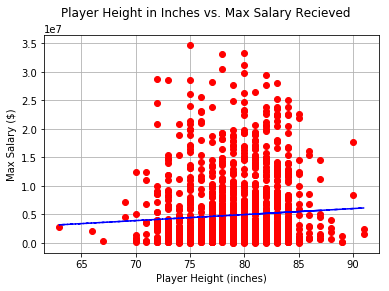

The slope of the line of best fit is 105591.20009693105
The correlation coefficient is 0.06395703097085799


In [17]:
#Creating Linear Regression for Height in Inches vs. Max Salary for all players

#Importing Stats and Matplotlib
from scipy.stats import linregress
import matplotlib.pyplot as plt
#Making Line of Best Fit
(slope, intercept, _, _, _) = linregress(heights1['height_inches'], heights1['salary'])
fit = slope * heights1['height_inches'] + intercept
#Making Plot
#Making plot
fig, ax = plt.subplots()
fig.suptitle("Player Height in Inches vs. Max Salary Recieved", fontsize=12)
ax.set_xlabel("Player Height (inches)")
ax.set_ylabel("Max Salary ($)")
ax.plot(heights1['height_inches'], heights1['salary'], color = 'red', linewidth=0, marker='o')
ax.plot(heights1['height_inches'], fit, 'b--')
plt.grid()
plt.show()
corr_coef = np.corrcoef(heights1['height_inches'], heights1['salary'])[0, 1]
print('The slope of the line of best fit is ' + str(slope))
print(f'The correlation coefficient is {corr_coef}')

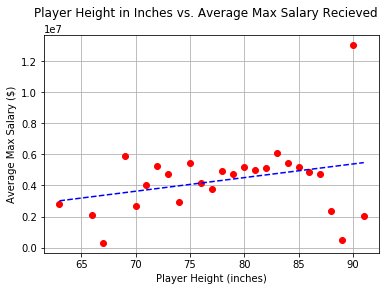

The slope of the line of best fit is 87847.06378979368
The correlation coefficient is 0.29499621506247503


In [18]:
#Creating Linear Regression for Height in Inches vs. Max Salary grouped by Height
#Making Line of Best Fit
(slope2, intercept2, _, _, _) = linregress(heights2.index.values, heights2['salary'])
fit2 = slope2 * heights2.index.values + intercept2
#Making Plot
#Making plot
fig2, ax2 = plt.subplots()
fig2.suptitle("Player Height in Inches vs. Average Max Salary Recieved", fontsize=12)
ax2.set_xlabel("Player Height (inches)")
ax2.set_ylabel("Average Max Salary ($)")
ax2.plot(heights2.index.values, heights2['salary'], color = 'red', linewidth=0, marker='o')
ax2.plot(heights2.index.values, fit2, 'b--')
plt.grid()
plt.show()
corr_coef2 = np.corrcoef(heights2.index.values, heights2['salary'])[0, 1]
print('The slope of the line of best fit is ' + str(slope2))
print(f'The correlation coefficient is {corr_coef2}')

In [19]:
#Making a draft table
draft_rank = final_a_df[['draft_rank', 'salary']]
draft_rank = draft_rank.groupby('draft_rank').mean()
draft_rank.head()

,salary
draft_rank,
1,1.228964e+07
2,1.041986e+07
3,1.228317e+07
4,1.060049e+07
5,9.935762e+06


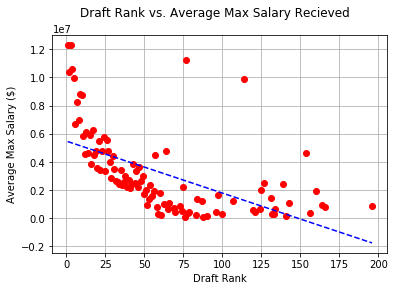

The slope of the line of best fit is -36946.44053206166
The correlation coefficient is -0.5768357125308243


In [20]:
#Making linear regression for draft rank vs. average salary
#Making Line of Best Fit
(slope3, intercept3, _, _, _) = linregress(draft_rank.index.values, draft_rank['salary'])
fit3 = slope3 * draft_rank.index.values + intercept3
#Making Plot
#Making plot
fig3, ax3 = plt.subplots()
fig3.suptitle("Draft Rank vs. Average Max Salary Recieved", fontsize=12)
ax3.set_xlabel("Draft Rank")
ax3.set_ylabel("Average Max Salary ($)")
ax3.plot(draft_rank.index.values, draft_rank['salary'], color = 'red', linewidth=0, marker='o')
ax3.plot(draft_rank.index.values, fit3, 'b--')
plt.grid()
plt.show()
corr_coef3 = np.corrcoef(draft_rank.index.values, draft_rank['salary'])[0, 1]
print('The slope of the line of best fit is ' + str(slope3))
print(f'The correlation coefficient is {corr_coef3}')

([<matplotlib.axis.XTick at 0x114abfe80>,
 <a list of 7 Text xticklabel objects>)

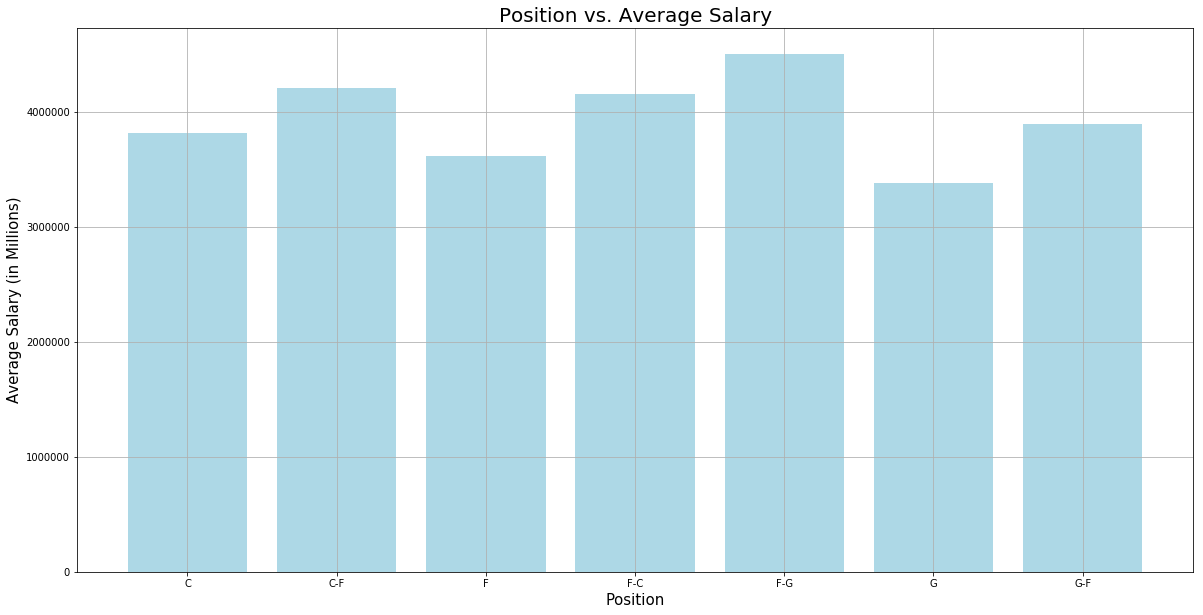

In [21]:
#Salary vs Position Analysis
group_by_pos = final_df.groupby('position').mean()

#Plot Average Rating By State
plt.figure(figsize = (20,10))
plt.bar(np.arange(0,len(group_by_pos),1),height = group_by_pos['salary'], color = 'lightblue', align = 'center', width = 0.8,)
plt.grid()
plt.title("Position vs. Average Salary", fontsize = 20)
plt.xlabel("Position", fontsize = 15)
plt.ylabel("Average Salary (in Millions)", fontsize = 15)
plt.xticks(np.arange(0,len(group_by_pos),1),('C','C-F','F','F-C','F-G','G','G-F'))

In [22]:
#Average Salary by Position over time Analysis

#Create years series
years = np.arange(1991,2019,1)
#Create new data frame
final_df1 = final_df.groupby(['position','season_end']).mean()
#Create series for each position
center = final_df1.loc['C',['salary']]
center_forward = final_df1.loc['C-F',['salary']]
forward = final_df1.loc['F',['salary']]
forward_center = final_df1.loc['F-C',['salary']]
forward_guard = final_df1.loc['F-G',['salary']]
guard = final_df1.loc['G',['salary']]
guard_forward = final_df1.loc['G-F',['salary']]

Text(0,0.5,'Salary (in Millions)')

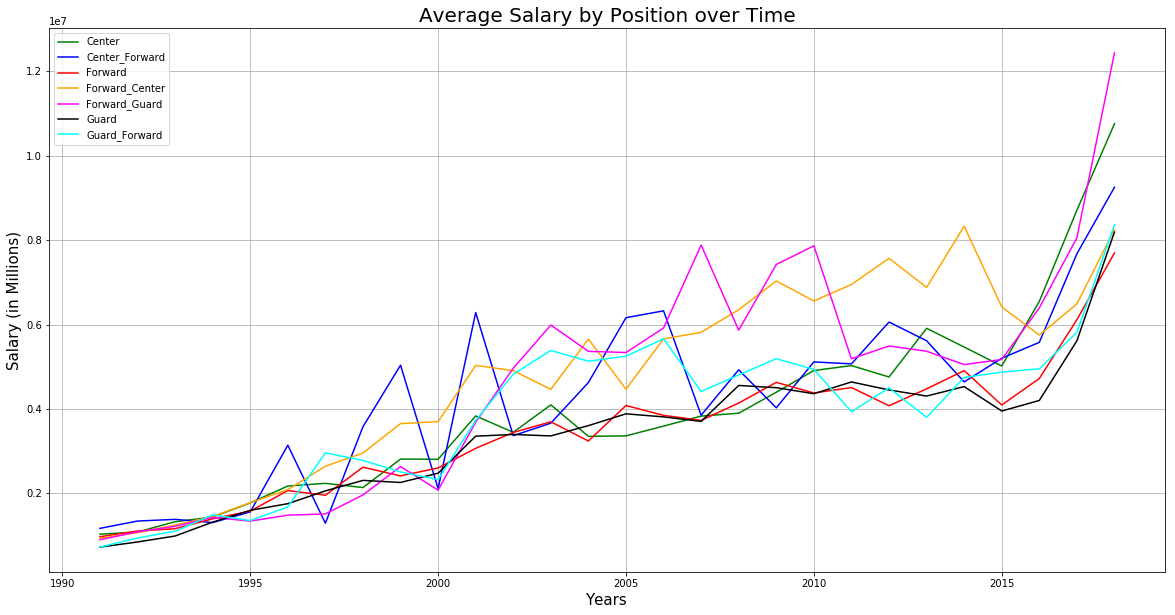

In [23]:
#Plot Line Graph

plt.figure(figsize = (20,10))

plt.plot(years,center['salary'],color='green',label='Center')
plt.plot(years,center_forward['salary'],color='blue',label='Center_Forward')
plt.plot(years,forward['salary'],color='red',label='Forward')
plt.plot(years,forward_center['salary'],color='orange',label='Forward_Center')
plt.plot(years,forward_guard['salary'],color='magenta',label='Forward_Guard')
plt.plot(years,guard['salary'],color='black',label='Guard')
plt.plot(years,guard_forward['salary'],color='cyan',label='Guard_Forward')

plt.grid()
plt.legend(loc="best")
plt.title("Average Salary by Position over Time", fontsize = 20)
plt.xlabel("Years", fontsize = 15)
plt.ylabel("Salary (in Millions)", fontsize = 15)